In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each tables

Station = Base.classes.station
Measurement = Base.classes.measurement


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#Activate Inspector
inspector = inspect(engine)

In [11]:
# Using the inspector to print the column names within the 'station' table and its types
columns1 = inspector.get_columns('Station')
for column in columns1:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns2 = inspector.get_columns('Measurement')
for column in columns2:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

engine.execute("SELECT * from Measurement").fetchall()

#Determine Maximum Date in Measurement table

max_date = (session.query(Measurement.date).order_by(Measurement.date.desc()).first())
max_date


('2017-08-23')

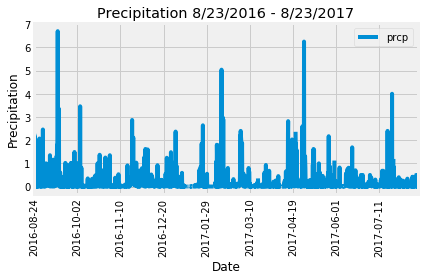

In [14]:
# Calculate the date 1 year ago from the last data point in the database

#Retrieve max date in table

max_date = list(np.ravel(max_date))[0]
max_date

max_date = dt.datetime.strptime(max_date, '%Y-%m-%d')

#Convert Year, Month, and Day into Integers for PY Calc

max_year = int(dt.datetime.strftime(max_date, '%Y'))
max_month = int(dt.datetime.strftime(max_date, '%m'))
max_day = int(dt.datetime.strftime(max_date, '%d'))

#Determine One year prior to max date using timedelta 

prior_year_date = dt.date(max_year, max_month, max_day) - dt.timedelta(days=365)
prior_year_date

# Perform a query to retrieve the data and precipitation scores

precip_data = (session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > prior_year_date).order_by(Measurement.date).all())
precip_data

# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.DataFrame(precip_data)
precip_df = precip_df.set_index('date')
precip_df

# Sort the dataframe by date

precip_df = precip_df.sort_index(ascending = True)
precip_df

# Use Pandas Plotting with Matplotlib to plot the data

precip_df.plot(rot=90)
plt.title("Precipitation 8/23/2016 - 8/23/2017")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dt
station_count = session.query(Station.station).count()
print(f"There are {station_count} stations")

There are 9 stations


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_activity = (session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all())
stations_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#Identify most active station
most_active_station = stations_activity[0][0]
print(f"The most active station is: {most_active_station}")

#Identify minimum recorded temp at the most active station

min_temp = (session.query(Measurement.tobs).filter(Measurement.station == most_active_station).order_by(Measurement.tobs).first())
min_temp = min_temp[0]
print(f"The coldest temperature recorded at {most_active_station} is : {min_temp} degrees")

#Identify maximim recorded temp at the most active station

max_temp = (session.query(Measurement.tobs).filter(Measurement.station == most_active_station).order_by(Measurement.tobs.desc()).first())
max_temp = max_temp[0]
print(f"The coldest temperature recorded at {most_active_station} is : {max_temp} degrees")

#Calculate average temperature at most active station

avg_temp = session.query(func.avg(Measurement.tobs).filter(Measurement.station == most_active_station)).all()
avg_temp = round(avg_temp[0][0],2)
print(f"The average temperature recorded at {most_active_station} is : {avg_temp} degrees")

The most active station is: USC00519281
The coldest temperature recorded at USC00519281 is : 54.0 degrees
The coldest temperature recorded at USC00519281 is : 85.0 degrees
The average temperature recorded at USC00519281 is : 71.66 degrees


In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

precip_data_active_station = (session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station, Measurement.date > prior_year_date).order_by(Measurement.date).all())
precip_data_active_station

#Convert to Dataframe, set date as index, sort by date

active_station_precip_df = pd.DataFrame(precip_data_active_station)
active_station_precip_df = active_station_precip_df.set_index('date')
active_station_precip_df = active_station_precip_df.sort_index(ascending = True)
active_station_precip_df

,tobs
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


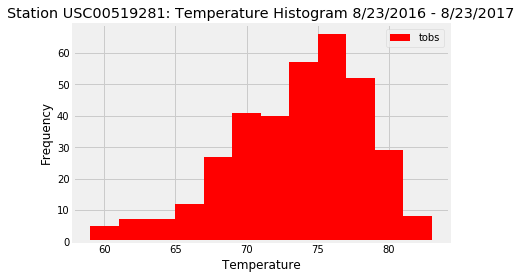

In [35]:
#Plot dataframe as a histogram with bins = 12

active_station_precip_df.plot(kind="hist", bins=12, color='r')
plt.title("Station USC00519281: Temperature Histogram 8/23/2016 - 8/23/2017")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
